# Nifty 50 predictor


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf

## Download and prepare data

### Download historical data for Nifty 50 index

We will use the `yfinance` library to download historical data for the Nifty 50 index. The data will be saved in a CSV file for further analysis.


In [34]:
DATA_DIR = '../data'
# Download Nifty 50 data
nifty_data = yf.download('^NSEI', start='2010-01-01', end='2025-07-20', interval='1d')
nifty_data.to_csv(f'{DATA_DIR}/nifty50.csv')

C:\Users\91958\AppData\Local\Temp\ipykernel_33536\2570681917.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_data = yf.download('^NSEI', start='2010-01-01', end='2025-07-20', interval='1d')
[*********************100%***********************]  1 of 1 completed


### Data preprocessing
We will preprocess the data by scaling the features and splitting it into training and testing sets. The `MinMaxScaler` from `sklearn.preprocessing` will be used to scale the data. The data will be split into training and testing sets using `train_test_split` from `sklearn.model_selection`.


In [35]:

df = pd.read_csv(
    f'{DATA_DIR}/nifty50.csv',
    skiprows=3,                # skip metadata lines
    names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'],  # set correct column names
)

# Display the first few rows of the dataframe
df.head(5)

,Date,Close,High,Low,Open,Volume
0,2010-01-04,5232.200195,5238.450195,5167.100098,5200.899902,0
1,2010-01-05,5277.899902,5288.350098,5242.399902,5277.149902,0
2,2010-01-06,5281.799805,5310.850098,5260.049805,5278.149902,0
3,2010-01-07,5263.100098,5302.549805,5244.750000,5281.799805,0
4,2010-01-08,5244.750000,5276.750000,5234.700195,5264.250000,0


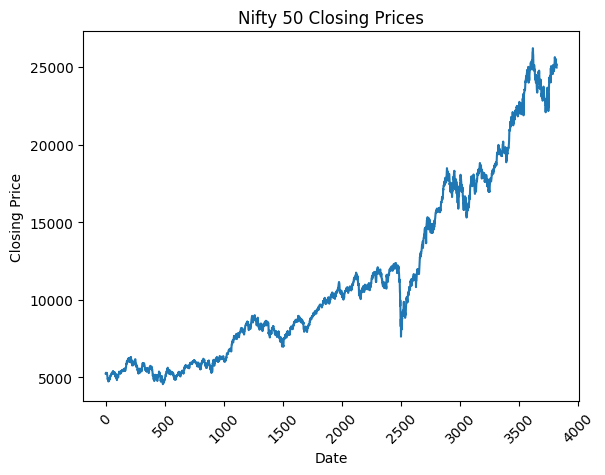

In [36]:
plt.plot(df['Close'])
plt.title('Nifty 50 Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()


In [37]:
df = df.drop(df[df['Volume'] == 0].index)
df

,Date,Close,High,Low,Open,Volume
747,2013-01-21,6082.299805,6094.350098,6065.100098,6085.750000,130900
748,2013-01-22,6048.500000,6101.299805,6040.500000,6080.149902,129000
749,2013-01-23,6054.299805,6069.799805,6021.149902,6052.850098,137000
750,2013-01-24,6019.350098,6065.299805,6007.850098,6046.200195,185200
751,2013-01-25,6074.649902,6080.549805,6014.450195,6024.500000,147600
...,...,...,...,...,...,...
3812,2025-07-14,25082.300781,25151.099609,25001.949219,25149.500000,259500
3813,2025-07-15,25195.800781,25245.199219,25088.449219,25089.500000,241300
3814,2025-07-16,25212.050781,25255.300781,25121.050781,25196.599609,228800
3815,2025-07-17,25111.449219,25238.349609,25101.000000,25230.750000,243400


In [38]:
close_data = df['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

scaled_data


array([[0.03809172],
       [0.03647691],
       [0.036754  ],
       ...,
       [0.95203299],
       [0.94722666],
       [0.94039237]])

In [39]:
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], X.shape[1], 1)


X.shape,y.shape, X

((2982, 60, 1),
 (2982,),
 array([[[0.03809172],
         [0.03647691],
         [0.036754  ],
         ...,
         [0.01163581],
         [0.01353969],
         [0.01929909]],
 
        [[0.03647691],
         [0.036754  ],
         [0.03508424],
         ...,
         [0.01353969],
         [0.01929909],
         [0.01928714]],
 
        [[0.036754  ],
         [0.03508424],
         [0.03772624],
         ...,
         [0.01929909],
         [0.01928714],
         [0.02379719]],
 
        ...,
 
        [[0.90211668],
         [0.90984201],
         [0.90591244],
         ...,
         [0.94906127],
         [0.94583406],
         [0.95125663]],
 
        [[0.90984201],
         [0.90591244],
         [0.89600612],
         ...,
         [0.94583406],
         [0.95125663],
         [0.95203299]],
 
        [[0.90591244],
         [0.89600612],
         [0.90982054],
         ...,
         [0.95125663],
         [0.95203299],
         [0.94722666]]]))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

In [42]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=25, batch_size=32)



Epoch 1/25


75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - loss: 0.0314
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0027
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0020
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.0018
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 0.0015
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0014
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 0.0011
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0014
Epoch 9/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0012
Epoch 10/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 9.8310e-04
Epoch 11/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 9.7613e-04
Epoch 12/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0011
Epoch 13/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0013
Epoch 14/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 9.2543e-04
Epoch 15/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.0518e-04
Test Loss: 0.0003755643265321851
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step
Mean Squared Error: 164538.0307243765
R^2 Score: 0.9949282608008392


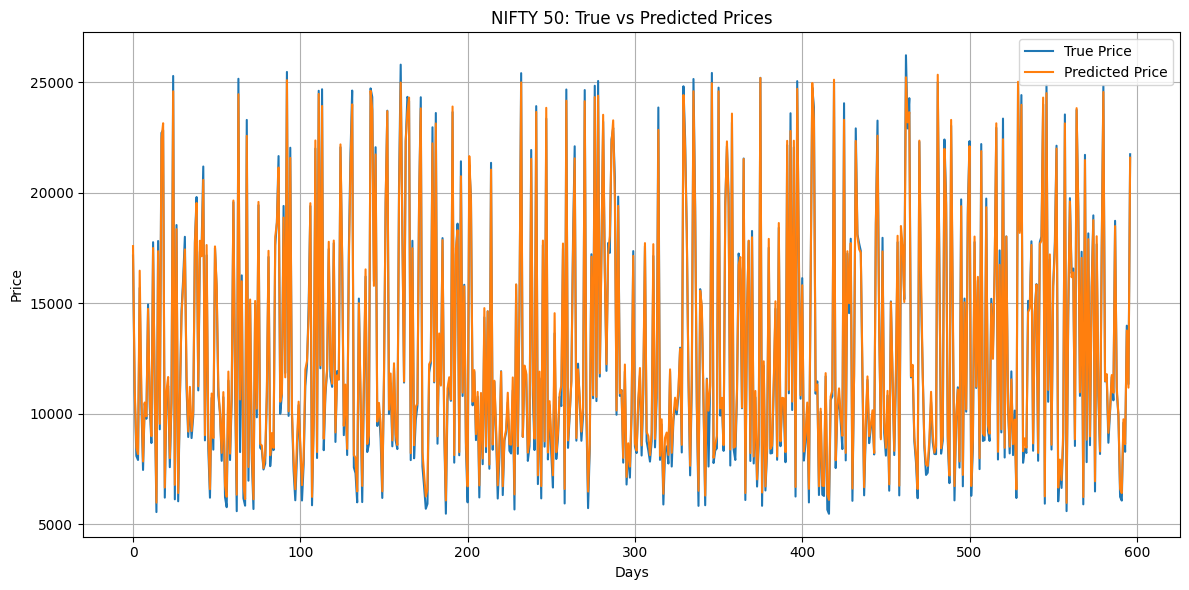

In [43]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions and true values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compute metrics
mse = mean_squared_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='True Price')
plt.plot(predictions, label='Predicted Price')
plt.title('NIFTY 50: True vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

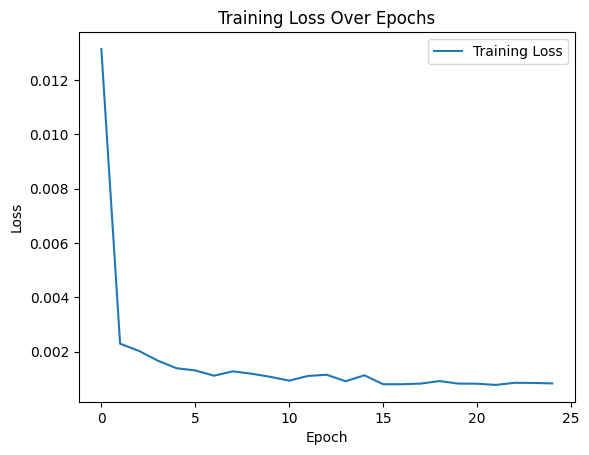

In [44]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [50]:
import joblib
import tensorflow as tf

# 1. Save the trained LSTM model
model.save("../models/lstm_stock_model.keras")  # Preferred format

# 2. Save the fitted scaler
joblib.dump(scaler, "../models/scaler.pkl")


['../models/scaler.pkl']